# Experiments & best model selection

This notebook has two parts:
1. Basic U-Net experiment runned on 12 different parametrizations for choosing best performing one given lowest validation loss.

2. Using parameters from (1) training of VGG-16 encoder UNet model.

author: Weronika Zawadzka

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import tensorflow as tf
import gc

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/myDrive/')

Mounted at /content/myDrive/


In [3]:
# go to directory where project.zip is
cd myDrive/MyDrive

/content/myDrive/MyDrive


In [5]:
# unzip project.zip
#!7z e project.7z
#!unzip project.zip

In [6]:
# set device as GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Data loading

Data is also augumented in this step, therfore this cell can take long to finish. (around 2 minutes)

In [7]:
from utils import data_loader
import importlib
# get current most recent version of the file
importlib.reload(data_loader)
data = data_loader.DataLoader(True) # True: with augumentations

# load datasets
X_train, y_train, X_test, X_valid, y_valid = data.X_train, data.y_train, data.X_test, data.X_valid, data.y_valid
print(f"training: x: {len(X_train)} & y: {len(y_train)}")
print(f"validation: x: {len(X_valid)} & y: {len(y_valid)}")
print(f"testing: x: {len(X_test)}")

training: x: 3840 & y: 3840
validation: x: 960 & y: 960
testing: x: 1000


In [8]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

print(type(X_train[0][0][0][0]))
print(type(y_train[0][0][0][0]))

(3840, 128, 128, 3)
(960, 128, 128, 3)
(3840, 128, 128, 1)
(960, 128, 128, 1)
<class 'numpy.float64'>
<class 'numpy.int32'>


___________________________________________________________________

## Basic U-NET

In [9]:
from models import unet
# set the input shape
input_img = Input(shape=X_train[0].shape)
# get current most recent version of the file
importlib.reload(unet)

<module 'models.unet' from '/content/myDrive/MyDrive/models/unet.py'>

### Defining variable parameters

In [10]:
# changing parameters for experiment for model selection
filter_sizes = [32,64]
dropouts = [True, False] # if to include dropout layers in the network
learning_rates = [1e-1, 1e-2, 1e-3]

### Building models

In [11]:
models = []

# iterate through each of changing parameters
for filter_size in filter_sizes:
    for dropout  in dropouts:
        for lr in learning_rates:
            # build a model given parameters
            model = unet.Binary_UNet(input_img, filter_size, doDropout = dropout, learning_rate= lr)
            net = model.network()

            # compile it using GPU
            with tf.device(device_name):
              net.compile(optimizer=model.optimizer, loss=model.loss, metrics=['accuracy'])

            # compile with CPU (not used)
            #net.compile(optimizer=model.optimizer, loss=model.loss, metrics=['accuracy'])

            # set the new name according to parameters
            net._name=f"{filter_size}_filters/dropout_{dropout}/lr_{lr}"

            # append to the list of models to test
            models.append(net)


print(len(models)) # how many models will take part in the experiment
for model in models:
    print(model.name)


12
32_filters/dropout_True/lr_0.1
32_filters/dropout_True/lr_0.01
32_filters/dropout_True/lr_0.001
32_filters/dropout_False/lr_0.1
32_filters/dropout_False/lr_0.01
32_filters/dropout_False/lr_0.001
64_filters/dropout_True/lr_0.1
64_filters/dropout_True/lr_0.01
64_filters/dropout_True/lr_0.001
64_filters/dropout_False/lr_0.1
64_filters/dropout_False/lr_0.01
64_filters/dropout_False/lr_0.001


### Experiments: 12 different parametrizations of UNet models

In [12]:
# prepare best model variables
best_model = None
best_loss = np.inf
best_hist = None

In [13]:
# iterate through each model from models to test
for model in models:
    # print model's name (and parameters)
    print(model.name)

    # train for 10 epochs with early stopping on validation loss with patience of 3
    # batch size of 32 so that colab is able to handle it
    hist = model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), epochs=10, callbacks=[EarlyStopping(monitor='loss', patience=3)])

    # check if current model has lower loss than current known lowest loss
    if hist.history['val_loss'][-1] < best_loss:
        # if yes, set it to best currently known model version
        best_loss = hist.history['val_loss'][-1]
        best_model = model
        best_hist = hist

    # free memory so that collab does not run out of recouses
    del model
    del hist
    gc.collect()

32_filters/dropout_True/lr_0.1
Epoch 1/10
120/120 [==============================] - 52s 262ms/step - loss: 0.3574 - accuracy: 0.8402 - val_loss: 3.6569 - val_accuracy: 0.6434
Epoch 2/10
120/120 [==============================] - 32s 268ms/step - loss: 0.2407 - accuracy: 0.9023 - val_loss: 2.7740 - val_accuracy: 0.7388
Epoch 3/10
120/120 [==============================] - 32s 265ms/step - loss: 0.2086 - accuracy: 0.9152 - val_loss: 0.2146 - val_accuracy: 0.9154
Epoch 4/10
120/120 [==============================] - 32s 265ms/step - loss: 0.1924 - accuracy: 0.9214 - val_loss: 0.2015 - val_accuracy: 0.9193
Epoch 5/10
120/120 [==============================] - 31s 259ms/step - loss: 0.1810 - accuracy: 0.9257 - val_loss: 0.2129 - val_accuracy: 0.9124
Epoch 6/10
120/120 [==============================] - 31s 258ms/step - loss: 0.1741 - accuracy: 0.9284 - val_loss: 0.1942 - val_accuracy: 0.9210
Epoch 7/10
120/120 [==============================] - 32s 265ms/step - loss: 0.1690 - accuracy: 0.9

### Save the best performing model (choice: lowest validation loss)

In [14]:
model = best_model
model.save('2unet_model') # save model with given name
model.save_weights('2unet_model_weights.h5') # save model's weights
model.name

'64_filters/dropout_False/lr_0.1'

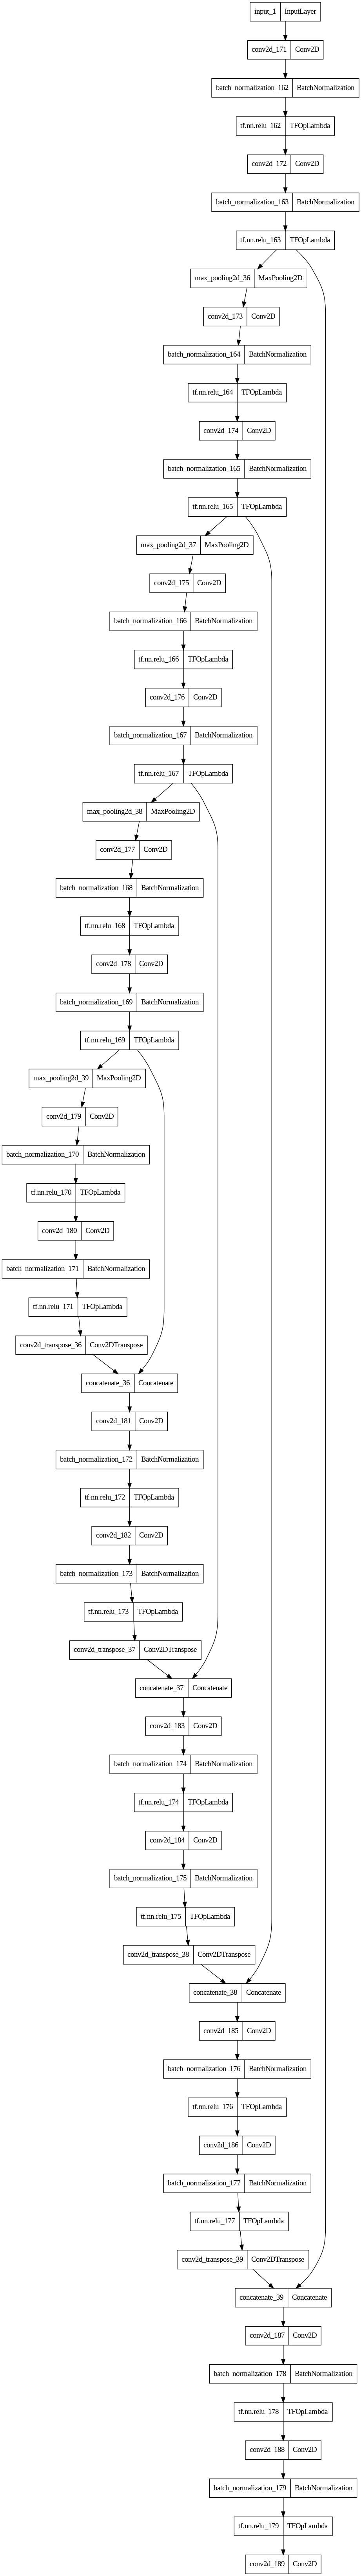

In [15]:
from tensorflow.keras.utils import plot_model
# plot flow chart of best performing basic U-Net model
plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

### Visualize

32/32 [==============================] - 7s 212ms/step


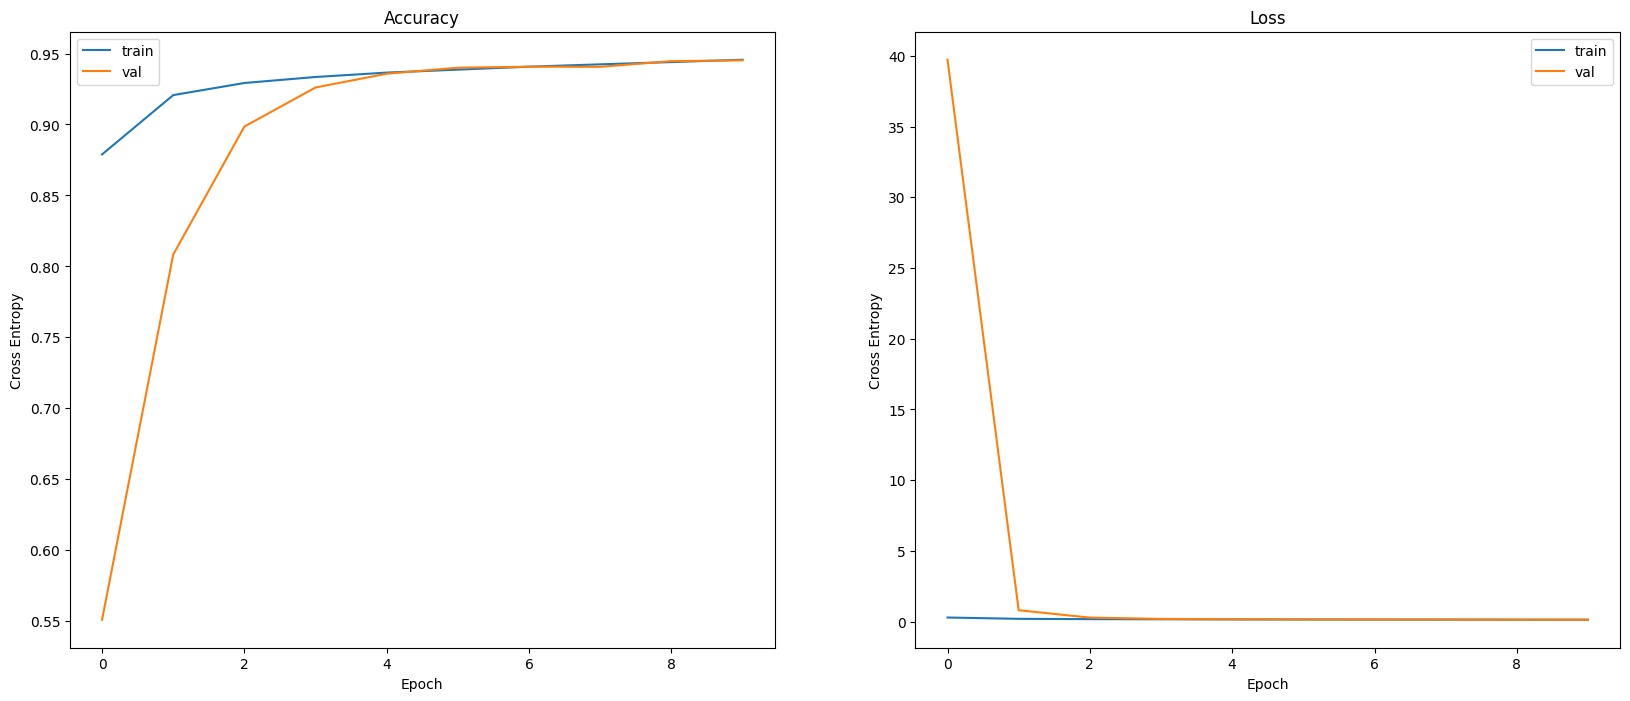

In [16]:
history = best_hist

# get predictios from test dataset
predictions = model.predict(X_test)

# create plot
fig = plt.figure(figsize=(20,8))
fig.add_subplot(1, 2, 1)

# plot accuracy
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
fig.add_subplot(1, 2, 2)

# plot loss
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

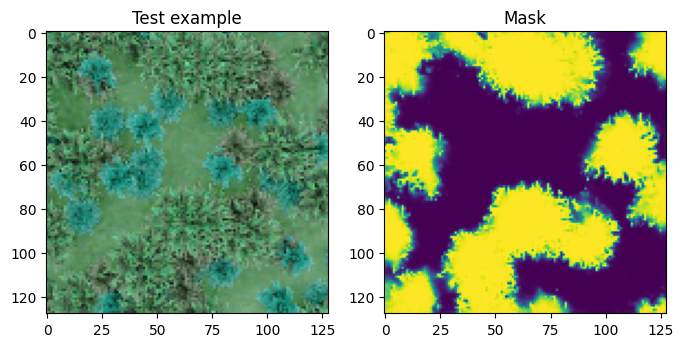

In [17]:
import random

# plot examplar test data and predicted mask
# prepare plot
fig = plt.figure(figsize=(8,8))
columns = 2
rows = 1
id = random.randint(0, len(X_test)-1)

# plot test image
fig.add_subplot(rows, columns, 1)
plt.title("Test example")
plt.imshow(X_test[id])

# plot predicted by our model mask
fig.add_subplot(rows, columns, 2)
plt.title(f"Mask")
plt.imshow(predictions[id])

plt.show()

# VGG16 encoder extension of Basic UNet


In [18]:
# VGG
from tensorflow.keras.applications import VGG16

# import VGG16 without last 3 layers
vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_img)

# get a summary of the model
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [19]:
# import VGG-16 encoder U-Net implemented model from models
from models import vgg16_unet
importlib.reload(vgg16_unet)

<module 'models.vgg16_unet' from '/content/myDrive/MyDrive/models/vgg16_unet.py'>

In [20]:
# define the model
model = vgg16_unet.VGG16_UNet(input_img, doBatchNorm = True, doDropout = False, learning_rate = 0.1)
optimizer = model.optimizer
loss_f = model.loss

# prepare for training
model = model.network()

In [21]:
# compile the model
model.compile(optimizer=optimizer, loss=loss_f, metrics=['accuracy'])

# train for 30 epochs with early stopping and batch size of 64
hist = model.fit(X_train, y_train, batch_size=64, validation_data=(X_valid, y_valid), epochs=30, callbacks=[EarlyStopping(monitor='loss', patience=3)])

Epoch 1/30
60/60 [==============================] - 84s 888ms/step - loss: 0.3170 - accuracy: 0.8657 - val_loss: 5.9196 - val_accuracy: 0.5992
Epoch 2/30
60/60 [==============================] - 53s 884ms/step - loss: 0.2254 - accuracy: 0.9098 - val_loss: 11.0509 - val_accuracy: 0.5743
Epoch 3/30
60/60 [==============================] - 53s 878ms/step - loss: 0.2051 - accuracy: 0.9174 - val_loss: 0.4796 - val_accuracy: 0.8977
Epoch 4/30
60/60 [==============================] - 53s 880ms/step - loss: 0.1922 - accuracy: 0.9220 - val_loss: 0.2571 - val_accuracy: 0.9135
Epoch 5/30
60/60 [==============================] - 54s 897ms/step - loss: 0.1832 - accuracy: 0.9252 - val_loss: 0.4305 - val_accuracy: 0.8815
Epoch 6/30
60/60 [==============================] - 53s 880ms/step - loss: 0.1747 - accuracy: 0.9284 - val_loss: 0.1826 - val_accuracy: 0.9270
Epoch 7/30
60/60 [==============================] - 54s 901ms/step - loss: 0.1678 - accuracy: 0.9312 - val_loss: 0.1785 - val_accuracy: 0.930

In [22]:
# save the state of the model
model.save('2vgg_unet_model')
model.save_weights('2vgg_unet_model_weights.h5')

32/32 [==============================] - 12s 191ms/step


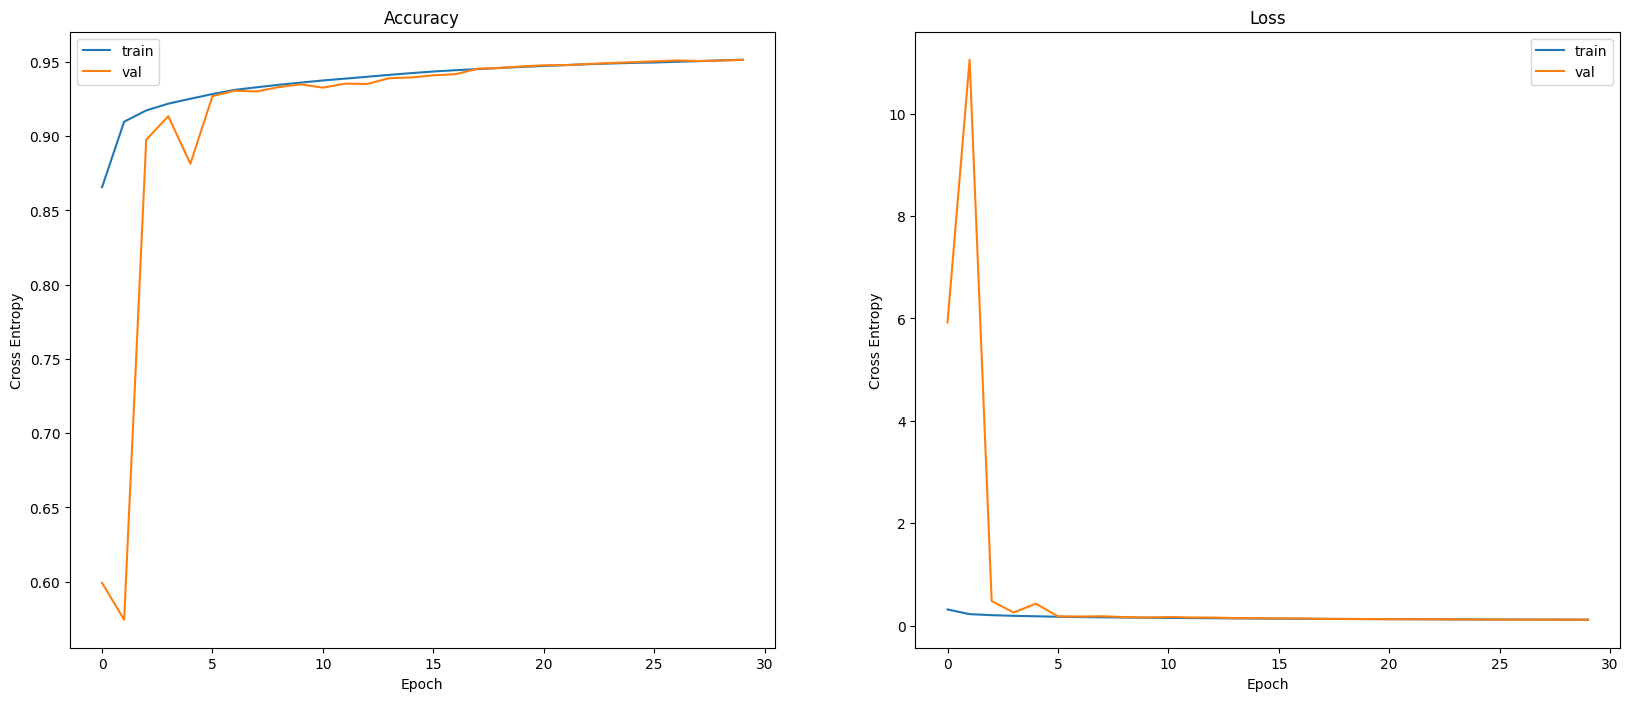

In [23]:
history = hist

# get predictions on test dataset
predictions = model.predict(X_test)

# prepare plot
fig = plt.figure(figsize=(20,8))
fig.add_subplot(1, 2, 1)

# plot accuracy
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
fig.add_subplot(1, 2, 2)

# plot loss
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

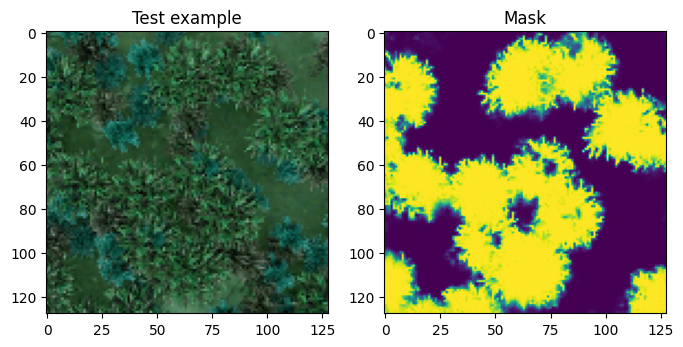

In [24]:
import random

# plot random test image and its predicted mask
fig = plt.figure(figsize=(8,8))
columns = 2
rows = 1
id = random.randint(0, len(X_test)-1)

# test image
fig.add_subplot(rows, columns, 1)
plt.title("Test example")
plt.imshow(X_test[id])

# predicted mask
fig.add_subplot(rows, columns, 2)
plt.title(f"Mask")
plt.imshow(predictions[id])

plt.show()